In [3]:
import numpy as np
import sympy as sy
from sympy.matrices import Matrix, zeros
import functools
from tqdm import tqdm

@functools.cache
def coeffs(points):
    n = len(points)
    
    A = Matrix(n, n, lambda i, j: points[j]**i)
    b = zeros(n, 1)
    b[2, 0] = 2
    return list(A.LUsolve(b).T.row(0))

for n in tqdm(range(1, 40)):
    coeffs(range(-n,n+1))

100%|██████████████████████████████████████████████████████████| 39/39 [00:43<00:00,  1.11s/it]


In [4]:
import numpy as np

class FDSchrodinger:
    def __init__(self, V, xbounds, ybounds, nx, ny, mx, my):
        self.cx = np.array(coeffs(range(-mx, mx+1)), dtype="float64")
        self.cy = np.array(coeffs(range(-my, my+1)), dtype="float64")
        self.xs = np.linspace(*xbounds, nx+1)
        self.ys = np.linspace(*ybounds, ny+1)
        X, Y = np.meshgrid(self.xs[1:-1], self.ys[1:-1])
        self.vs = V(X, Y)
        hx = (xbounds[1] - xbounds[0])/nx
        hy = (ybounds[-1] - ybounds[0])/ny
        self.cx /= -hx**2
        self.cy /= -hy**2
    
    def system(self):
        nx = self.xs.shape[0] - 2
        ny = self.ys.shape[0] - 2
        N = nx*ny
        mx = self.cx.shape[0]//2
        my = self.cy.shape[0]//2
        
        B = np.zeros((N, N), dtype="float64")
        for ix in range(nx):
            for iy in range(ny):
                lowx = max(-mx, -ix)
                highx = min(mx + 1, nx - ix)
                B[iy*nx + ix, iy*nx + ix + lowx : iy*nx + ix + highx] += self.cx[mx + lowx : mx + highx]
                
                lowy = max(-my, -iy)
                highy = min(my + 1, ny - iy)
                B[iy*nx + ix, (iy + lowy)*nx + ix : (iy + highy)*nx + ix : nx] += self.cy[my + lowy : my + highy]
        
        B += np.diag(self.vs.flatten())
        
        return B

In [18]:
def V(x, y):
    return x ** 2 + y ** 2

fds = FDSchrodinger(V, (-10, 10), (-10, 10), 48, 48, 20, 20)

In [19]:
Es, vs = np.linalg.eigh(fds.system())
sorted(Es)[:50]

[1.9999999999996139,
 3.9999999999929337,
 3.9999999999929505,
 5.999999999884781,
 5.999999999884827,
 5.999999999986249,
 7.999999998730772,
 7.999999998730842,
 7.999999999878144,
 7.999999999878199,
 9.999999989597429,
 9.999999989597455,
 9.999999998724105,
 9.999999998724155,
 9.9999999997701,
 11.999999932387894,
 11.999999932387981,
 11.999999989590746,
 11.999999989590778,
 11.999999998615971,
 11.999999998615976,
 13.999999636612593,
 13.999999636612626,
 13.999999932381298,
 13.999999932381314,
 13.999999989482628,
 13.999999989482678,
 13.999999997461911,
 15.999998336889764,
 15.99999833688982,
 15.999999636605946,
 15.99999963660597,
 15.999999932273225,
 15.99999993227327,
 15.999999988328605,
 15.999999988328605,
 17.99999337526216,
 17.999993375262164,
 17.999998336883127,
 17.99999833688317,
 17.99999963649782,
 17.99999963649785,
 17.9999999311191,
 17.999999931119156,
 17.999999979195312,
 19.999976637986798,
 19.999976637986855,
 19.9999933752555,
 19.9999933752555

In [20]:
import scipy.sparse as sps

sorted(np.real(sps.linalg.eigs(sps.csr_matrix(fds.system()), which='SR', k=50)[0]))

[1.9999999999995606,
 3.999999999992912,
 3.999999999992955,
 5.99999999988483,
 5.999999999884938,
 5.999999999986269,
 7.99999999873079,
 7.999999998730848,
 7.999999999878223,
 7.999999999878236,
 9.999999989597455,
 9.999999989597475,
 9.999999998724016,
 9.999999998724096,
 9.99999999977009,
 11.999999932387972,
 11.999999932387983,
 11.999999989590847,
 11.99999998959085,
 11.999999998616019,
 11.999999998616044,
 13.999999636612635,
 13.999999636612745,
 13.999999932381256,
 13.999999932381307,
 13.999999989482701,
 13.999999989482731,
 13.999999997461845,
 15.999998336889744,
 15.99999833688986,
 15.999999636605866,
 15.99999963660589,
 15.99999993227319,
 15.999999932273296,
 15.99999998832855,
 15.9999999883286,
 17.99999337526223,
 17.999993375262232,
 17.999998336883234,
 17.999998336883372,
 17.99999963649777,
 17.99999963649796,
 17.999999931119184,
 17.999999931119223,
 17.99999997919541,
 19.99997663798679,
 19.99997663798705,
 19.999993375255567,
 19.999993375255755,
 

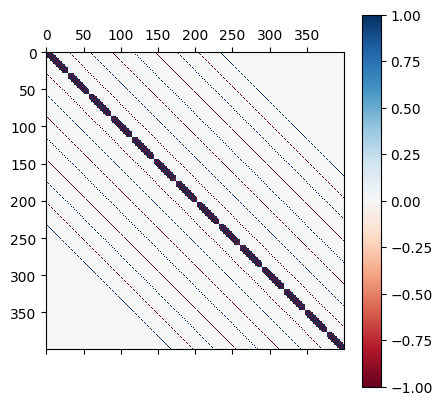

In [204]:
import matplotlib.pyplot as plt

plt.matshow(np.sign(fds.system())[:400, :400], vmin=-1, vmax=1, cmap="RdBu")
plt.colorbar()